In [ ]:
pip install qiskit qiskit_optimization qiskit-aer pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 643.4/643.4 kB 33.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 91.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.6/167.6 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 94.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 11.4 M

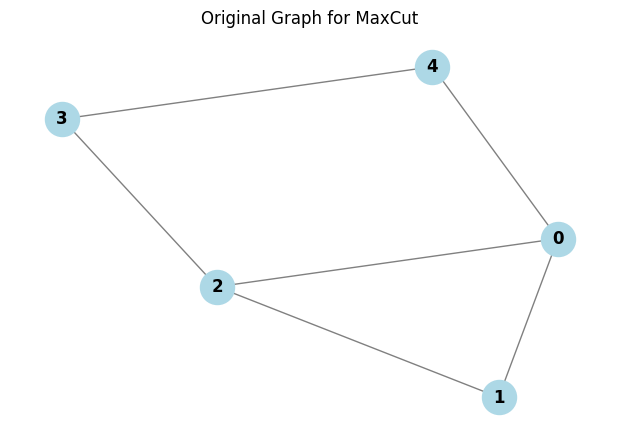

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# define a sample graph
num_nodes = 5
graph = nx.Graph()
graph.add_nodes_from(range(num_nodes))

graph.add_edges_from([(0,1),(0,2),(1,2),(2,3),(3,4),(4,0)])

pos = nx.spring_layout(graph, seed=42)
plt.figure(figsize=(6,4))
nx.draw(graph, pos=pos, with_labels=True, node_color='lightblue',
        node_size=600, edge_color='gray', font_weight='bold')
plt.title("Original Graph for MaxCut")
plt.show()


In [ ]:
from qiskit.quantum_info import SparsePauliOp

def build_maxcut_hamiltonian(graph):
    num_qubits = graph.number_of_nodes()
    edges = list(graph.edges())
    num_edges = len(edges)

    pauli_terms = ["I"*num_qubits]
    coeffs = [num_edges/2]

    # add each edge term
    for (u, v) in edges:
        z_term = ["I"] * num_qubits
        z_term[u] = "Z"
        z_term[v] = "Z"
        pauli_terms.append("".join(z_term))
        coeffs.append(-0.5)

    return SparsePauliOp.from_list(list(zip(pauli_terms, coeffs)))

H_maxcut = build_maxcut_hamiltonian(graph)
print("MaxCut Hamiltonian:")
print(H_maxcut)


MaxCut Hamiltonian:
SparsePauliOp(['IIIII', 'ZZIII', 'ZIZII', 'ZIIIZ', 'IZZII', 'IIZZI', 'IIIZZ'],
              coeffs=[ 3. +0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j])


Ansatz: multiple layers of parameterized rotations and entangling gates (hardware-efficient ansatz)

- Layers of R_y and R_z rotations on each qubit
- Followed by entangling CNOT gates in a ring topology
- Repeat for a few layers

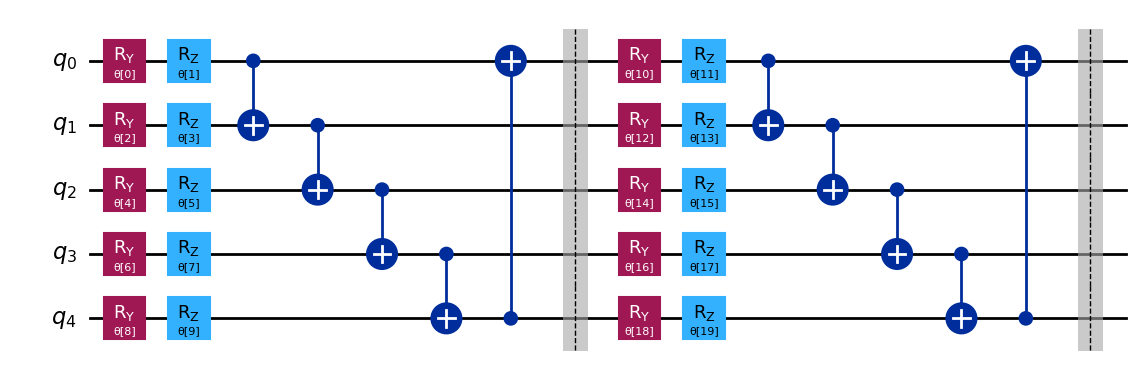

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

# HEA with multiple layers, each layer with parameterized RY, RZ, and CNOT gates in a ring
def hardware_efficient_ansatz(num_qubits, num_layers, params):

    qc = QuantumCircuit(num_qubits)
    # initial state: start from |0...0>
    # could add Hadamards for superposition if desired, but let's keep |0> initial

    param_idx = 0
    for layer in range(num_layers):
        # single-qubit rotations
        for q in range(num_qubits):
            qc.ry(params[param_idx], q)
            param_idx += 1
            qc.rz(params[param_idx], q)
            param_idx += 1

        # ring of CNOTs
        for q in range(num_qubits):
            qc.cx(q, (q+1) % num_qubits)

        qc.barrier()


    return qc

num_layers = 2
num_params_per_layer = 2 * num_nodes  # RY and RZ per qubit
total_params = num_params_per_layer * num_layers
params = ParameterVector("θ", length=total_params)

# test building the ansatz
test_ansatz = hardware_efficient_ansatz(num_nodes, num_layers, params)
test_ansatz.draw("mpl")


In [ ]:
# from ionq import IonQProvider
# provider = IonQProvider("YOUR_API_KEY")
# backend_ionq = provider.get_backend("ionq_simulator")  # or "ionq_qpu"

In [ ]:
from qiskit_aer import AerSimulator
from qiskit import transpile
import numpy as np

backend = AerSimulator(method='statevector')

def run_circuit(circuit, shots=1024, use_statevector=True):
    """
    if use_statevector=True, return exact state
    otherwise, run with shots and return averaged results
    """
    # sim = AerSimulator(method='statevector')
    # transpiled = transpile(circuit, backend)
    # result = backend.run(transpiled).result()
    # return result.get_statevector()

    # if use_statevector:
    #     transpiled = transpile(circuit, backend)
    #     result = backend.run(transpiled).result()
    #     return result.get_statevector()
    # else:

    #     sim = AerSimulator("automatic")
    #     transpiled = transpile(circuit, sim)
    #     result = sim.run(transpiled, shots=shots).result()
    #     return result.get_counts()
    if use_statevector:

        has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
        if has_measure:

            pass

        # append save_statevector if not already present
        save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
        if not save_inst_present:
            circuit.save_statevector()

        sim = AerSimulator(method='statevector')
        t_circ = transpile(circuit, sim)
        result = sim.run(t_circ).result()

        # retrieve the statevector
        # if run multiple circuits, specify the correct index
        # assume a single circuit, so index 0
        try:
            statevector = result.get_statevector(t_circ)
        except:
            # f get_statevector fails, try directly from result.data
            statevector = result.data(0).get('statevector', None)

        return statevector

    else:
        # run with shots and return counts
        sim = AerSimulator()
        t_circ = transpile(circuit, sim)
        result = sim.run(t_circ, shots=shots).result()
        return result.get_counts()

def expectation_value_from_state(state, pauli, coeff):
    """
    compute expectation value <pauli> for given state and multiply by coeff
    """
    val = state.expectation_value(pauli)
    return np.real(val) * coeff

def measure_expectation_value(state, hamiltonian):
    """
    compute <H> given state and H. we assume statevector again.
    for hardware decompose H into commuting groups and measure separately, and then average results from multiple runs
    """
    val = 0.0
    for p, c in zip(hamiltonian.paulis, hamiltonian.coeffs):
        val += expectation_value_from_state(state, p, c)
    return val


In [ ]:
def param_shift_state(ansatz_func, base_params, idx, shift):
    shifted_params = base_params.copy()
    shifted_params[idx] += shift
    qc = ansatz_func(num_nodes, num_layers, shifted_params)
    return run_circuit(qc, use_statevector=True)

def qite_matrices(ansatz_func, current_params, hamiltonian):
    """
    compute A and C for QITE:
    A_ij = Re(<∂θ_i ψ|∂θ_j ψ>)
    C_i  = Re(<∂θ_i ψ|H|ψ>)

    using parameter shift:
    |∂θ_i ψ> ~ [|ψ(θ+π/2 e_i)> - |ψ(θ-π/2 e_i)>]/2

    C_i = Re(<∂θ_i ψ|H|ψ>) similarly computed
    """
    num_params = len(current_params)

    base_state = param_shift_state(ansatz_func, current_params, 0, 0.0)

    deriv_states = []
    plus_states = []
    minus_states = []
    for i in range(num_params):
        plus_st = param_shift_state(ansatz_func, current_params, i, np.pi/2)
        minus_st = param_shift_state(ansatz_func, current_params, i, -np.pi/2)
        deriv = (plus_st - minus_st) / 2.0
        deriv_states.append(deriv)
        plus_states.append(plus_st)
        minus_states.append(minus_st)

    # metric tensor A
    A = np.zeros((num_params, num_params), dtype=float)
    for i in range(num_params):
        for j in range(num_params):
            A[i,j] = np.real(np.vdot(deriv_states[i], deriv_states[j]))

    # force vector C
    # C_i = Re(<∂θ_i ψ|H|ψ>) = (E_plus - E_minus)/2 where E_plus = <ψ(θ+π/2 e_i)|H|ψ> and similarly for minus. because <∂θ_i ψ| = ( <ψ(θ+π/2 e_i)| - <ψ(θ-π/2 e_i)| ) / 2 and H|ψ> = |ψ> since we measure from left
    C = np.zeros(num_params, dtype=float)
    for i in range(num_params):
        E_plus = measure_expectation_value(plus_states[i], hamiltonian)
        E_minus = measure_expectation_value(minus_states[i], hamiltonian)
        C[i] = (E_plus - E_minus)/2.0

    return A, C


QITE loop:

- At each step, compute A and C
- Solve for Δθ
- Update parameters
- Compute and log energy

Also added a small regularization term to A to prevent numerical issues

In [ ]:
def varQITE_loop(ansatz_func, hamiltonian, initial_params, steps=20, reg=1e-6):
    params = initial_params.copy()
    energy_history = []
    params_history = [params.copy()]

    # initial energy
    base_circ = ansatz_func(num_nodes, num_layers, params)
    base_state = run_circuit(base_circ, use_statevector=True)
    current_energy = measure_expectation_value(base_state, hamiltonian)
    energy_history.append(current_energy)

    for step in range(steps):
        A, C = qite_matrices(ansatz_func, params, hamiltonian)
        A += reg*np.eye(len(params))  # regularization

        # solve linear system
        delta_params = np.linalg.solve(A, -C)
        params += delta_params

        # compute new energy
        base_circ = ansatz_func(num_nodes, num_layers, params)
        base_state = run_circuit(base_circ, use_statevector=True)
        current_energy = measure_expectation_value(base_state, hamiltonian)

        energy_history.append(current_energy)
        params_history.append(params.copy())
        print(f"Step {step+1}/{steps}, Energy: {current_energy:.6f}")

    return params_history, energy_history


In [ ]:
initial_params = np.random.uniform(-np.pi, np.pi, total_params)
params_history, energy_history = varQITE_loop(hardware_efficient_ansatz, H_maxcut, initial_params, steps=10)

<ipython-input-107-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-107-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-107-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-inpu

Step 1/10, Energy: 2.604240+0.000000j


<ipython-input-107-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-107-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-107-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-inpu

Step 2/10, Energy: 2.150301+0.000000j


<ipython-input-107-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-107-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-107-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-inpu

Step 3/10, Energy: 1.021567+0.000000j


<ipython-input-107-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-107-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-107-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-inpu

Step 4/10, Energy: 0.980305+0.000000j


<ipython-input-107-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-107-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-107-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-inpu

Step 5/10, Energy: 1.476697+0.000000j


<ipython-input-107-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-107-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-107-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-inpu

Step 6/10, Energy: 1.496327+0.000000j


<ipython-input-107-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-107-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-107-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-inpu

Step 7/10, Energy: 1.852393+0.000000j


<ipython-input-107-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-107-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-107-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-inpu

Step 8/10, Energy: 1.936854+0.000000j


<ipython-input-107-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-107-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-107-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-inpu

Step 9/10, Energy: 2.332612+0.000000j


<ipython-input-107-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-107-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-107-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-inpu

Step 10/10, Energy: 2.315231+0.000000j


In [ ]:
final_circ = hardware_efficient_ansatz(num_nodes, num_layers, params_history[-1])
final_circ.measure_all()

sim = AerSimulator()
t_circ = transpile(final_circ, sim)
result = sim.run(t_circ, shots=1000).result()
counts = result.get_counts()
print("Final distribution:", counts)

def bitstring_to_cut(bitstring):
    set_0 = [i for i, b in enumerate(bitstring) if b == '0']
    set_1 = [i for i, b in enumerate(bitstring) if b == '1']

    cut_edges = 0
    for (u,v) in graph.edges():
        if (u in set_0 and v in set_1) or (u in set_1 and v in set_0):
            cut_edges += 1
    return cut_edges

best_bitstring = max(counts, key=counts.get)
cut_value = bitstring_to_cut(best_bitstring)
print(f"Best bitstring: {best_bitstring}, Cut Value: {cut_value}")


Final distribution: {'01010': 1, '01110': 1, '00111': 3, '00011': 1, '00110': 4, '11001': 7, '10110': 3, '00100': 68, '11000': 6, '11111': 127, '00101': 1, '10001': 2, '01001': 6, '00000': 149, '00010': 13, '01111': 102, '01101': 19, '10000': 257, '11011': 52, '10100': 118, '01011': 46, '11101': 7, '10101': 3, '10010': 4}
Best bitstring: 10000, Cut Value: 3


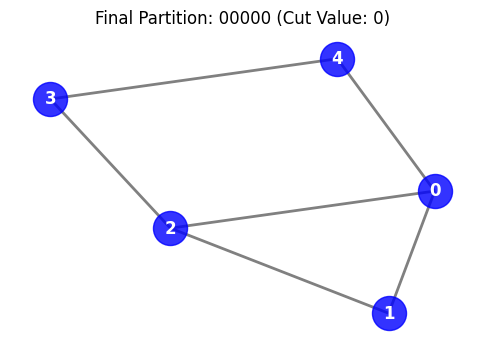

In [ ]:
set_A = [i for i, b in enumerate(best_bitstring) if b == '1']
set_B = [i for i, b in enumerate(best_bitstring) if b == '0']

cut_edges = []
non_cut_edges = []
for (u, v) in graph.edges():
    if (u in set_A and v in set_B) or (u in set_B and v in set_A):
        cut_edges.append((u, v))
    else:
        non_cut_edges.append((u, v))


plt.figure(figsize=(6,4))

nx.draw_networkx_nodes(graph, pos=pos, nodelist=set_A, node_color='red', node_size=600, alpha=0.8)
nx.draw_networkx_nodes(graph, pos=pos, nodelist=set_B, node_color='blue', node_size=600, alpha=0.8)

nx.draw_networkx_edges(graph, pos=pos, edgelist=non_cut_edges, edge_color='gray', width=2)
nx.draw_networkx_edges(graph, pos=pos, edgelist=cut_edges, edge_color='green', width=2, style='dashed')

nx.draw_networkx_labels(graph, pos=pos, font_color='white', font_weight='bold')

plt.title(f"Final Partition: {best_bitstring} (Cut Value: {cut_value})")
plt.axis('off')
plt.show()


In [ ]:
import numpy as np

best_energy = None
best_params = None
best_bitstring = None
final_counts = None
num_repetitions = 10

for run_idx in range(num_repetitions):
    initial_params = np.random.uniform(-np.pi, np.pi, total_params)
    params_history, energy_history = varQITE_loop(
        hardware_efficient_ansatz,
        H_maxcut,
        initial_params,
        steps=10,
        reg=1e-6
    )

    # evaluate final energy again
    final_energy = energy_history[-1]
    if best_energy is None or final_energy < best_energy:
        best_energy = final_energy
        best_params = params_history[-1]

print(f"Best energy found after {num_repetitions} runs: {best_energy}")


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 1/10, Energy: 2.423476+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 2/10, Energy: 2.118662+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 3/10, Energy: 2.084748+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 4/10, Energy: 2.130044+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 5/10, Energy: 2.004605+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 6/10, Energy: 1.935143+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 7/10, Energy: 1.550863+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 8/10, Energy: 0.190740+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 9/10, Energy: 0.317524+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 10/10, Energy: 1.235602+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 1/10, Energy: 2.233827+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 2/10, Energy: 1.154994+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 3/10, Energy: 2.624468+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 4/10, Energy: 2.638023+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 5/10, Energy: 2.782457+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 6/10, Energy: 2.486350+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 7/10, Energy: 2.791263+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 8/10, Energy: 3.391604+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 9/10, Energy: 2.123817+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 10/10, Energy: 2.101106+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 1/10, Energy: 2.109348+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 2/10, Energy: 1.438860+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 3/10, Energy: 1.290682+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 4/10, Energy: 2.012000+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 5/10, Energy: 1.927385+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 6/10, Energy: 3.918981+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 7/10, Energy: 2.838137+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 8/10, Energy: 2.569220+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 9/10, Energy: 2.595057+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 10/10, Energy: 2.214101+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 1/10, Energy: 2.174553+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 2/10, Energy: 2.060761+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 3/10, Energy: 2.030622+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 4/10, Energy: 2.003181+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 5/10, Energy: 1.707072+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 6/10, Energy: 0.626538+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 7/10, Energy: 0.715781+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 8/10, Energy: 2.211476+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 9/10, Energy: 2.434423+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 10/10, Energy: 1.320219+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 1/10, Energy: 2.905054+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 2/10, Energy: 2.122763+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 3/10, Energy: 2.012121+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 4/10, Energy: 3.033065+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 5/10, Energy: 2.899010+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 6/10, Energy: 2.922075+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 7/10, Energy: 2.007823+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 8/10, Energy: 0.387201+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 9/10, Energy: 1.265709+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 10/10, Energy: 2.343924+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 1/10, Energy: 2.605487+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 2/10, Energy: 1.796653+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 3/10, Energy: 1.919327+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 4/10, Energy: 1.628985+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 5/10, Energy: 2.578986+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 6/10, Energy: 2.040886+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 7/10, Energy: 2.395361+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 8/10, Energy: 2.141263+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 9/10, Energy: 1.407570+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 10/10, Energy: 1.213465+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 1/10, Energy: 2.840258+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 2/10, Energy: 2.565945+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 3/10, Energy: 2.260053+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 4/10, Energy: 2.092514+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 5/10, Energy: 2.032898+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 6/10, Energy: 1.864000+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 7/10, Energy: 1.192160+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 8/10, Energy: 1.244226+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 9/10, Energy: 2.166210+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 10/10, Energy: 2.361078+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 1/10, Energy: 1.762186+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 2/10, Energy: 2.353958+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 3/10, Energy: 1.459520+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 4/10, Energy: 2.431177+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 5/10, Energy: 2.006037+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 6/10, Energy: 3.885896+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 7/10, Energy: 1.790813+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 8/10, Energy: 1.544879+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 9/10, Energy: 1.860718+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 10/10, Energy: 3.801294+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 1/10, Energy: 2.127879+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 2/10, Energy: 1.959805+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 3/10, Energy: 1.920715+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 4/10, Energy: 1.913279+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 5/10, Energy: 1.816876+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 6/10, Energy: 1.015647+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 7/10, Energy: 0.436456+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 8/10, Energy: 2.142357+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 9/10, Energy: 1.112012+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 10/10, Energy: 2.220262+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 1/10, Energy: 1.959860+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 2/10, Energy: 0.942826+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 3/10, Energy: 1.921822+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 4/10, Energy: 1.548259+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 5/10, Energy: 2.507297+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 6/10, Energy: 3.613935+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 7/10, Energy: 2.595455+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 8/10, Energy: 1.666771+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 9/10, Energy: 0.943400+0.000000j


<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-88-ba8cdf499ccc>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8

Step 10/10, Energy: 3.262266+0.000000j
Best energy found after 10 runs: (1.2134647845770938+0j)


In [ ]:
final_circ = hardware_efficient_ansatz(num_nodes, num_layers, best_params)
final_circ.measure_all()

sim = AerSimulator()
t_circ = transpile(final_circ, sim)
result = sim.run(t_circ, shots=1000).result()
counts = result.get_counts()
print("Final distribution:", counts)

def bitstring_to_cut(bitstring):
    set_0 = [i for i, b in enumerate(bitstring) if b == '0']
    set_1 = [i for i, b in enumerate(bitstring) if b == '1']

    cut_edges = 0
    for (u,v) in graph.edges():
        if (u in set_0 and v in set_1) or (u in set_1 and v in set_0):
            cut_edges += 1
    return cut_edges

best_bitstring = max(counts, key=counts.get)
cut_value = bitstring_to_cut(best_bitstring)
print(f"Best bitstring: {best_bitstring}, Cut Value: {cut_value}")


Final distribution: {'10100': 154, '11101': 12, '01011': 1, '01010': 110, '00000': 646, '00010': 1, '11111': 53, '01001': 5, '01000': 1, '11110': 9, '10110': 3, '10111': 1, '11100': 1, '00001': 3}
Best bitstring: 00000, Cut Value: 0




---



Tuning parameters

In [ ]:
# parameters to tune
num_layers = 3
num_repetitions = 2
qite_steps = 20
reg = 1e-5

def enhanced_ansatz(num_qubits, num_layers, params):
    """
    enhanced hardware-efficient ansatz
    """
    qc = QuantumCircuit(num_qubits)
    param_idx = 0
    for layer in range(num_layers):

        for q in range(num_qubits):
            qc.ry(params[param_idx], q)
            param_idx += 1
            qc.rz(params[param_idx], q)
            param_idx += 1

        for q in range(num_qubits):
            qc.cx(q, (q+1) % num_qubits)

        for q in range(num_qubits):
            qc.ry(params[param_idx], q)
            param_idx += 1
            qc.rz(params[param_idx], q)
            param_idx += 1

        for q in range(num_qubits):
            qc.cx((q+1) % num_qubits, q)

    return qc

# with two sets of RY,RZ per layer and two entangling stages, we have:
# per layer, per qubit: 4 parameters (2 RY+RZ cycles)
# total: num_layers * num_qubits * 4 parameters
num_qubits = graph.number_of_nodes()
total_params = num_layers * num_qubits * 4


In [ ]:
import numpy as np

best_energy = None
best_params = None
best_bitstring = None
final_counts = None

for run_idx in range(num_repetitions):
    initial_params = np.random.uniform(-np.pi, np.pi, total_params)
    params_history, energy_history = varQITE_loop(
        enhanced_ansatz,
        H_maxcut,
        initial_params,
        steps=qite_steps,
        reg=reg
    )

    # evaluate final energy again (it should be the last in energy_history)
    final_energy = energy_history[-1]
    if best_energy is None or final_energy < best_energy:
        best_energy = final_energy
        best_params = params_history[-1]

print(f"Best energy found after {num_repetitions} runs: {best_energy}")


<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6c

Step 1/20, Energy: 3.179433+0.000000j


<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6c

Step 2/20, Energy: 3.052266+0.000000j


<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6c

Step 3/20, Energy: 3.097423+0.000000j


<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6c

Step 4/20, Energy: 2.421727+0.000000j


<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6c

Step 5/20, Energy: 3.227311+0.000000j


<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6c

Step 6/20, Energy: 2.691278+0.000000j


<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6c

Step 7/20, Energy: 3.063626+0.000000j


<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6c

Step 8/20, Energy: 2.855812+0.000000j


<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6c

Step 9/20, Energy: 3.233286+0.000000j


<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6c

Step 10/20, Energy: 2.821898+0.000000j


<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6c

Step 11/20, Energy: 2.982171+0.000000j


<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6c

Step 12/20, Energy: 2.948393+0.000000j


<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6c

Step 13/20, Energy: 2.831728+0.000000j


<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6c

Step 14/20, Energy: 2.958528+0.000000j


<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6c

Step 15/20, Energy: 2.590737+0.000000j


<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6c

Step 16/20, Energy: 3.232953+0.000000j


<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6c

Step 17/20, Energy: 3.159277+0.000000j


<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6c

Step 18/20, Energy: 3.240801+0.000000j


<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6c

Step 19/20, Energy: 3.371622+0.000000j


<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6c

Step 20/20, Energy: 3.081558+0.000000j


<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6c

Step 1/20, Energy: 2.715159+0.000000j


<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6c

Step 2/20, Energy: 2.915428+0.000000j


<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6c

Step 3/20, Energy: 3.358982+0.000000j


<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6c

Step 4/20, Energy: 3.130213+0.000000j


<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6c

Step 5/20, Energy: 3.286427+0.000000j


<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6c

Step 6/20, Energy: 2.811541+0.000000j


<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6c

Step 7/20, Energy: 2.949444+0.000000j


<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6c

Step 8/20, Energy: 2.994982+0.000000j


<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6c

Step 9/20, Energy: 3.330264+0.000000j


<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6c

Step 10/20, Energy: 3.305061+0.000000j


<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6c

Step 11/20, Energy: 3.045980+0.000000j


<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6c

Step 12/20, Energy: 2.684979+0.000000j


<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6c

Step 13/20, Energy: 2.775211+0.000000j


<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6c

Step 14/20, Energy: 2.715458+0.000000j


<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6c

Step 15/20, Energy: 2.907216+0.000000j


<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6c

Step 16/20, Energy: 3.229116+0.000000j


<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6c

Step 17/20, Energy: 3.199108+0.000000j


<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6c

Step 18/20, Energy: 2.911342+0.000000j


<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6c

Step 19/20, Energy: 2.983079+0.000000j


<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6c

Step 20/20, Energy: 2.846760+0.000000j
Best energy found after 2 runs: (2.846759829191832+0j)


<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)


In [ ]:
# build the final circuit with the best parameters
final_circ = enhanced_ansatz(num_qubits, num_layers, best_params)
final_circ.measure_all()

sim = AerSimulator()
t_circ = transpile(final_circ, sim)
result = sim.run(t_circ, shots=2000).result()
counts = result.get_counts()

# find best bitstring from the sampled distribution
best_bitstring = max(counts, key=counts.get)

def bitstring_to_cut(bitstring, graph):
    set_0 = [i for i, b in enumerate(bitstring) if b == '0']
    set_1 = [i for i, b in enumerate(bitstring) if b == '1']
    cut_edges = 0
    for (u,v) in graph.edges():
        if (u in set_0 and v in set_1) or (u in set_1 and v in set_0):
            cut_edges += 1
    return cut_edges

cut_value = bitstring_to_cut(best_bitstring, graph)
print(f"Best bitstring: {best_bitstring}, Cut Value: {cut_value}")
print("Counts for reference:", counts)


Best bitstring: 00010, Cut Value: 2
Counts for reference: {'10000': 2, '11110': 58, '00100': 38, '01001': 53, '00101': 83, '11010': 43, '10001': 9, '01010': 84, '00010': 239, '10110': 46, '11100': 138, '10100': 15, '10111': 48, '10101': 52, '10010': 13, '11101': 144, '00011': 121, '00111': 39, '10011': 130, '01111': 49, '11011': 6, '11111': 37, '11000': 31, '01101': 120, '00001': 129, '00110': 36, '00000': 28, '11001': 21, '01110': 37, '01011': 57, '01000': 53, '01100': 41}




---



## NN to optimize params for varQITE

In [ ]:
def generate_training_data(ansatz_func, hamiltonian, num_samples=2000, reg=1e-6):
    data = []
    for _ in range(num_samples):
        # random initial parameters
        current_params = np.random.uniform(-np.pi, np.pi, len(params))

        # compute A, C
        A, C = qite_matrices(ansatz_func, current_params, hamiltonian)
        A += reg * np.eye(len(current_params))

        # solve linear system for ground-truth delta_theta
        delta_theta = np.linalg.solve(A, -C)

        # store sample
        data.append((A, C, current_params, delta_theta))
    return data


In [ ]:
def prepare_data_for_nn(data):
    X = []
    Y = []
    for (A, C, theta, delta_theta) in data:
        A_flat = A.flatten()
        x = np.concatenate([A_flat, C, theta])
        y = delta_theta
        X.append(x)
        Y.append(y)
    X = np.array(X, dtype=np.float32)
    Y = np.array(Y, dtype=np.float32)
    return X, Y


In [ ]:
import torch.nn as nn
import torch.optim as optim

class VarQITEOptimizer(nn.Module):
    def __init__(self, num_params):
        super(VarQITEOptimizer, self).__init__()
        input_dim = num_params*(num_params+2)
        hidden_dim = 64
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, num_params)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
num_samples = 50
training_data = generate_training_data(hardware_efficient_ansatz, H_maxcut, num_samples=num_samples)
X, Y = prepare_data_for_nn(training_data)

print("Data shape:", X.shape, Y.shape)

<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6c

KeyboardInterrupt: 

In [ ]:
train_ratio = 0.8
train_size = int(train_ratio * num_samples)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

In [ ]:
import torch

model = VarQITEOptimizer(len(params))
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

X_train_t = torch.tensor(X_train)
Y_train_t = torch.tensor(Y_train)
X_test_t = torch.tensor(X_test)
Y_test_t = torch.tensor(Y_test)

batch_size = 64
epochs = 50
for epoch in range(epochs):

    perm = np.random.permutation(X_train_t.size(0))
    X_train_t = X_train_t[perm]
    Y_train_t = Y_train_t[perm]

    for i in range(0, X_train_t.size(0), batch_size):
        xb = X_train_t[i:i+batch_size]
        yb = Y_train_t[i:i+batch_size]

        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()


    with torch.no_grad():
        test_pred = model(X_test_t)
        test_loss = criterion(test_pred, Y_test_t).item()

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Test Loss: {test_loss:.6f}")


Epoch 10/50, Test Loss: 0.357325
Epoch 20/50, Test Loss: 0.373205
Epoch 30/50, Test Loss: 0.418341
Epoch 40/50, Test Loss: 0.476404
Epoch 50/50, Test Loss: 0.529722




---



In [ ]:
def varQITE_loop_with_model(ansatz_func, hamiltonian, initial_params, steps=10, reg=1e-6):
    params_current = initial_params.copy()

    for step in range(steps):
        A, C = qite_matrices(ansatz_func, params_current, hamiltonian)

        A_flat = A.flatten()
        input_vec = np.concatenate([A_flat, C, params_current]).astype(np.float32)
        input_t = torch.tensor(input_vec).unsqueeze(0)  # (1, input_dim)


        with torch.no_grad():
            delta_theta = model(input_t).detach().numpy().squeeze()


        params_current = params_current + delta_theta

    return params_current



In [ ]:
final_params = varQITE_loop_with_model(hardware_efficient_ansatz, H_maxcut, initial_params, steps=10)

<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:41: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  save_inst_present = any(op.name == 'save_statevector' for op, _, _ in circuit.data)
<ipython-input-8-6cbfc4b616d5>:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  has_measure = any(op.name == 'measure' for op, _, _ in circuit.data)
<ipython-input-8-6c

In [ ]:
final_circuit = hardware_efficient_ansatz(num_nodes, num_layers, final_params)
final_circuit.measure_all()

final_circuit.measure_all()

sim = AerSimulator()
t_circuit = transpile(final_circuit, sim)
result = sim.run(t_circuit, shots=1000).result()
counts = result.get_counts()
print("Final distribution:", counts)

Final distribution: {'00000 00000': 3, '10000 10000': 7, '10010 10010': 6, '00001 00001': 2, '11110 11110': 6, '00100 00100': 5, '11100 11100': 24, '01011 01011': 6, '01111 01111': 27, '00110 00110': 18, '00101 00101': 3, '01000 01000': 8, '00111 00111': 54, '01110 01110': 1, '11011 11011': 20, '00010 00010': 257, '11101 11101': 84, '00011 00011': 24, '10110 10110': 195, '01100 01100': 9, '10111 10111': 4, '11001 11001': 65, '01101 01101': 40, '11111 11111': 4, '01010 01010': 3, '10011 10011': 26, '11000 11000': 14, '11010 11010': 3, '01001 01001': 82}


In [ ]:
def compute_cut_from_bitstring(bitstring, graph):
    set_A = [i for i, b in enumerate(bitstring) if b == '1']
    set_B = [i for i, b in enumerate(bitstring) if b == '0']
    cut_edges = 0
    for (u,v) in graph.edges():
        if (u in set_A and v in set_B) or (u in set_B and v in set_A):
            cut_edges += 1
    return cut_edges

best_bitstring = max(counts, key=counts.get)
cut_value = compute_cut_from_bitstring(best_bitstring, graph)
print(f"Best bitstring: {best_bitstring}, Cut Value: {cut_value}")

Best bitstring: 00010 00010, Cut Value: 2


## Solving Using NN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import networkx as nx
import numpy as np

#############################################
# Graph Neural Network
#############################################

class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats, bias=False)

    def forward(self, x, adj):
        out = torch.matmul(adj, x)
        out = self.linear(out)
        return out

class SimpleGCN(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats, num_layers=2):
        super(SimpleGCN, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(GCNLayer(in_feats, hidden_feats))
        for _ in range(num_layers-2):
            self.layers.append(GCNLayer(hidden_feats, hidden_feats))
        self.layers.append(GCNLayer(hidden_feats, out_feats))

    def forward(self, x, adj):
        for i, layer in enumerate(self.layers):
            x = layer(x, adj)
            if i < len(self.layers)-1:
                x = F.relu(x)
        return x

#############################################
# Model to predict probabilities for MaxCut
#############################################

class MaxCutModel(nn.Module):
    def __init__(self, num_nodes, input_dim=16, hidden_dim=32, num_layers=2):
        super(MaxCutModel, self).__init__()
        self.node_feats = nn.Parameter(torch.randn(num_nodes, input_dim))
        self.gnn = SimpleGCN(input_dim, hidden_dim, 1, num_layers=num_layers)

    def forward(self, adj):
        out = self.gnn(self.node_feats, adj)
        p = torch.sigmoid(out).squeeze()
        return p

#############################################
# Loss Function: Negative Expected Cut
#############################################

def expected_cut_value(p, edges):
    # p: probability vector (N)
    # edges: list of (u,v)
    # cut between sets is sum of edges where endpoints differ
    # expected value for edge (u,v):
    # P(u in A, v in B) + P(u in B, v in A) = p_u(1 - p_v) + (1 - p_u)p_v = p_u - 2p_up_v + p_v = (p_u + p_v) - 2p_up_v
    # sum this over all edges
    pu = p
    val = 0.0
    for (u,v) in edges:
        val += (pu[u] + pu[v] - 2*pu[u]*pu[v])
    return val

#############################################
# Example 0_0
#############################################

graph = nx.Graph()
num_nodes = 5
graph.add_nodes_from(range(num_nodes))
# original cycle edges
edges = [(0,1),(1,2),(2,3),(3,4),(4,0)]
# add an extra chord
edges.append((0,2))
graph.add_edges_from(edges)

adj = nx.to_numpy_array(graph)
deg = np.sum(adj, axis=1)
deg_inv_sqrt = np.diag(1.0/np.sqrt(deg))
norm_adj = deg_inv_sqrt @ adj @ deg_inv_sqrt

adj_torch = torch.tensor(norm_adj, dtype=torch.float)

model = MaxCutModel(num_nodes=num_nodes, input_dim=16, hidden_dim=32, num_layers=2)
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 200
for epoch in range(epochs):
    optimizer.zero_grad()
    p = model(adj_torch)
    cut_val = expected_cut_value(p, edges)
    loss = -cut_val
    loss.backward()
    optimizer.step()

    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Cut value (expected): {cut_val.item():.4f}")

final_p = model(adj_torch).detach().numpy()
partition = (final_p > 0.5).astype(int)

def compute_cut(partition, edges):
    set_A = [i for i, b in enumerate(partition) if b == 1]
    set_B = [i for i, b in enumerate(partition) if b == 0]
    cut_count = 0
    for (u,v) in edges:
        if (u in set_A and v in set_B) or (u in set_B and v in set_A):
            cut_count += 1
    return cut_count

final_cut = compute_cut(partition, edges)
print("Final partition:", ''.join(map(str, partition)), f"Cut Value: {final_cut}")

Epoch 20/200, Cut value (expected): 4.7765
Epoch 40/200, Cut value (expected): 4.9995
Epoch 60/200, Cut value (expected): 4.9999
Epoch 80/200, Cut value (expected): 4.9999
Epoch 100/200, Cut value (expected): 4.9999
Epoch 120/200, Cut value (expected): 4.9999
Epoch 140/200, Cut value (expected): 4.9999
Epoch 160/200, Cut value (expected): 4.9999
Epoch 180/200, Cut value (expected): 4.9999
Epoch 200/200, Cut value (expected): 4.9999
Final partition: 00101 Cut Value: 5
